<a href="https://colab.research.google.com/github/leenasilvoster/Mytest/blob/master/imdb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from keras.datasets import imdb
from keras import optimizers
from keras import losses
from keras import metrics
import matplotlib.pyplot as plt

In [ ]:
import numpy as np

In [ ]:
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(
num_words=10000)


17473536/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/keras/datasets/imdb.py:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/keras/datasets/imdb.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the nda

In [ ]:
train_data[0]

In [ ]:
train_labels[0]

1

In [ ]:
print(np.unique(train_labels))

[0 1]


In [ ]:
max([max(sequence) for sequence in train_data])

9999

In [ ]:
word_index = imdb.get_word_index()
reverse_word_index = dict(
[(value, key) for (key, value) in word_index.items()])
decoded_review = ' '.join(
[reverse_word_index.get(i - 3, '?') for i in train_data[0]])

1654784/1641221 [==============================] - 0s 0us/step


In [ ]:
def vectorize_sequences(sequences, dimension=10000):
  results = np.zeros((len(sequences), dimension))
  for i, sequence in enumerate(sequences):
    results[i, sequence] = 1.
  return results
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In [ ]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

In [ ]:
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

In [ ]:
def recall(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    all_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    
    recall = true_positives / (all_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
from keras import models
from keras import layers
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.callbacks import ModelCheckpoint, EarlyStopping
# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=7)
cvscores = []
#checkpoint = ModelCheckpoint(filepath,monitor='val_acc', verbose=1,save_best_only=True,mode='max',save_weights_only=True)
#callbacks_list =[checkpoint]
model_checkpoint = ModelCheckpoint(filepath="mymodel_{epoch}", monitor='val_acc',mode='max',verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', min_delta=1e-2, patience=15, verbose=1, mode='auto', baseline=None, 
                             restore_best_weights=False)
for train, test in kfold.split(x_train, y_train):
  #create a model
  model = models.Sequential()
  model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
  model.add(layers.Dense(16, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))
  model.summary()
  #Compiling the model
  #model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])
  model.compile(optimizer=optimizers.RMSprop(learning_rate=0.001),
  loss=losses.binary_crossentropy,
  metrics=['acc'])
  history = model.fit(x_train,
  y_train,
  epochs=20,
  batch_size=512,
  callbacks=[model_checkpoint, earlystopper],
  validation_split=0.2)
  #model.fit(x_train, y_train, batch_size=64, validation_split=0.2, epochs=1)
  # evaluate the model
  scores = model.evaluate(x_test, y_test, verbose=0)
  print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
  cvscores.append(scores[1] * 100)
  print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
  pred = model.predict(x_test)
  cm = confusion_matrix(y_test, np.rint(pred))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                160016    
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
40/40 [==============================] - 17s 46ms/step - loss: 0.5602 - acc: 0.7231 - val_loss: 0.3364 - val_acc: 0.8762

Epoch 00001: val_acc improved from -inf to 0.87620, saving model to mymodel_1
INFO:tensorflow:Assets written to: mymodel_1/assets
Epoch 2/20
40/40 [==============================] - 1s 30ms/step - loss: 0.2701 - acc: 0.9112 - val_loss: 0.2763 - va

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import classification_report
y_pred = np.argmax(pred, axis=1)
# Print f1, precision, and recall scores
print(precision_score(y_test, y_pred , average="macro"))
print(recall_score(y_test, y_pred , average="macro"))
print(f1_score(y_test, y_pred , average="macro"))
print(classification_report(y_test, y_pred))

0.25
0.5
0.3333333333333333
              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67     12500
         1.0       0.00      0.00      0.00     12500

    accuracy                           0.50     25000
   macro avg       0.25      0.50      0.33     25000
weighted avg       0.25      0.50      0.33     25000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import roc_curve
y_pred = model.predict(x_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)

In [ ]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

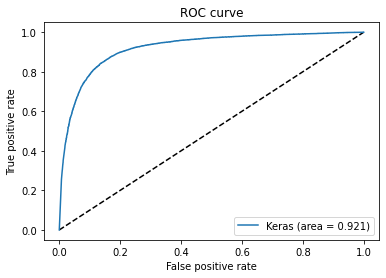

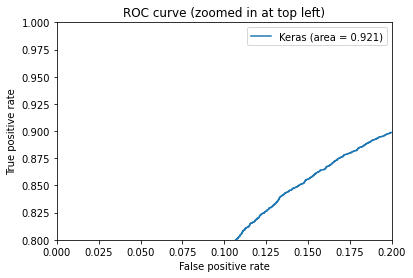

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.plt.figure(1)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

In [ ]:
n_classes = 2
# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()


# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

IndexError: ignored

IndexError: ignored

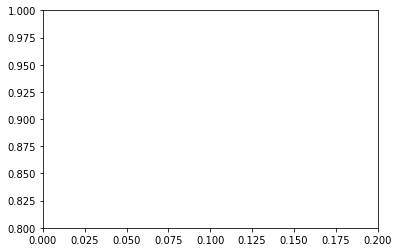

In [ ]:
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr_keras["micro"], tpr_keras["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [ ]:
scores

[0.6528936624526978, 0.8528000116348267]

In [ ]:
print("Confusion Matrix is:", + cm)

Confusion Matrix is: [[10594  1906]
 [ 1774 10726]]


In [ ]:
pred
y_test

array([0., 1., 1., ..., 0., 0., 0.], dtype=float32)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, pred)
#cmd = ConfusionMatrixDisplay(cm, display_labels=['business','health'])
#cmd.plot()

ValueError: ignored

In [ ]:
#The model definition
from keras import models
from keras import layers
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

In [ ]:
#Compiling the model
model.compile(optimizer='rmsprop',
loss='binary_crossentropy',
metrics=['accuracy'])

In [ ]:
#Configuring the optimizer
from keras import optimizers
model.compile(optimizer=optimizers.RMSprop(learning_rate=0.001),
loss='binary_crossentropy',
metrics=['accuracy'])

In [ ]:
#Using custom losses and metrics
from keras import losses
from keras import metrics
model.compile(optimizer=optimizers.RMSprop(learning_rate=0.001),
loss=losses.binary_crossentropy,
metrics=[metrics.binary_accuracy])


In [ ]:
#Setting aside a validation set
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

In [ ]:
#Training your model
model.compile(optimizer='rmsprop',
loss='binary_crossentropy',
metrics=['acc'])
history = model.fit(partial_x_train,
partial_y_train,
epochs=20,
batch_size=512,
validation_data=(x_val, y_val))

Epoch 1/20
30/30 [==============================] - 16s 47ms/step - loss: 0.5837 - acc: 0.7017 - val_loss: 0.3772 - val_acc: 0.8732
Epoch 2/20
30/30 [==============================] - 1s 18ms/step - loss: 0.3197 - acc: 0.8968 - val_loss: 0.3023 - val_acc: 0.8886
Epoch 3/20
30/30 [==============================] - 1s 19ms/step - loss: 0.2310 - acc: 0.9296 - val_loss: 0.2830 - val_acc: 0.8879
Epoch 4/20
30/30 [==============================] - 1s 19ms/step - loss: 0.1756 - acc: 0.9443 - val_loss: 0.2913 - val_acc: 0.8838
Epoch 5/20
30/30 [==============================] - 1s 19ms/step - loss: 0.1407 - acc: 0.9548 - val_loss: 0.2780 - val_acc: 0.8888
Epoch 6/20
30/30 [==============================] - 1s 19ms/step - loss: 0.1113 - acc: 0.9682 - val_loss: 0.2916 - val_acc: 0.8884
Epoch 7/20
30/30 [==============================] - 1s 18ms/step - loss: 0.0957 - acc: 0.9728 - val_loss: 0.3114 - val_acc: 0.8853
Epoch 8/20
30/30 [==============================] - 1s 19ms/step - loss: 0.0815 - 

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

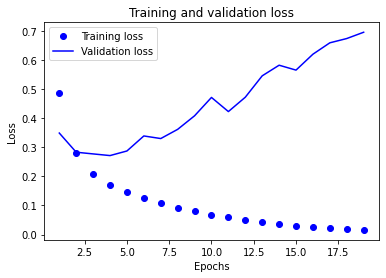

In [ ]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc = history_dict['accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

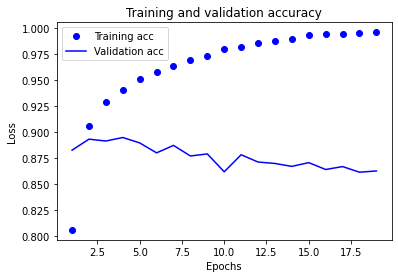

In [ ]:
#plt.clf()
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#Retraining a model from scratch
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
loss='binary_crossentropy',
metrics=['accuracy'])
model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/4
49/49 [==============================] - 1s 11ms/step - loss: 0.5432 - accuracy: 0.7306
Epoch 2/4
49/49 [==============================] - 1s 12ms/step - loss: 0.2665 - accuracy: 0.9064
Epoch 3/4
49/49 [==============================] - 1s 11ms/step - loss: 0.1955 - accuracy: 0.9323
Epoch 4/4
782/782 [==============================] - 2s 2ms/step - loss: 0.3705 - accuracy: 0.8561


In [ ]:
results

[0.3705272972583771, 0.8561199903488159]

In [ ]:
#Using a trained network to generate predictions on new data
model.predict(x_test)

array([[0.31140727],
       [0.99979514],
       [0.99532795],
       ...,
       [0.2397323 ],
       [0.16981585],
       [0.86622673]], dtype=float32)

In [ ]:
from keras import models
from keras import layers
def build_model():
  model = models.Sequential()
  model.add(layers.Dense(64, activation='relu',
  input_shape=(train_data.shape[1],)))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(1))
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  return model

In [ ]:
#Building the history of successive mean K-fold validation scores
average_mae_history = [
np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

In [ ]:
#Plotting validation scores
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [ ]:
#Plotting validation scores, excluding the first 10 data points
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points
smooth_mae_history = smooth_curve(average_mae_history[10:])
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [ ]:
#Training the final model
model = build_model()
model.fit(train_data, train_targets,
epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

In [ ]:
#Adding dropout to the IMDB network
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()
model.compile(optimizer='rmsprop',
loss='binary_crossentropy',
metrics=['accuracy'])
model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)

In [ ]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc = history_dict['acc']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#@title
#Validating your approach using K-fold validation
#K-fold validation
import numpy as np
k = 4
num_val_samples = len(train_data) // k
num_epochs = 10
all_scores = []
train_data = partial_x_train
train_targets = partial_y_train
for i in range(k):
  print('processing fold #', i)
  val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
  val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
  partial_train_data = np.concatenate(
  [train_data[:i * num_val_samples],
  train_data[(i + 1) * num_val_samples:]],axis=0)
  partial_train_targets = np.concatenate(
  [train_targets[:i * num_val_samples],
  train_targets[(i + 1) * num_val_samples:]],axis=0)
  model = build_model()
  model.fit(partial_train_data, partial_train_targets,
  epochs=num_epochs, batch_size=1, verbose=0)
  val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
  all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


ValueError: ignored

In [ ]:
#Saving the validation logs at each fold
num_epochs = 500
all_mae_histories = []
for i in range(k):
 print('processing fold #', i)
 val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
 val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
 partial_train_data = np.concatenate(
 [train_data[:i * num_val_samples],
 train_data[(i + 1) * num_val_samples:]],axis=0)

In [ ]:
#Saving the validation logs at each fold
partial_train_targets = np.concatenate(
[train_targets[:i * num_val_samples],
train_targets[(i + 1) * num_val_samples:]],
axis=0)
model = build_model()
history = model.fit(partial_train_data, partial_train_targets,
validation_data=(val_data, val_targets),
epochs=num_epochs, batch_size=1, verbose=0)
mae_history = history.history['val_mean_absolute_error']
all_mae_histories.append(mae_history)